# This notebook analyzes and forecasts Ethereum daily close prices using time series modeling techniques.

## Imports Libraries

In [44]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error



warnings.filterwarnings("ignore")
scaler = MinMaxScaler()

## Preparing data

In [45]:

df = pd.read_csv('../data/all_data.csv', parse_dates=['open_time'])
df.set_index('open_time', inplace=True)
df = df[['close']]
df.head()
print(df[['close']])

              close
open_time          
2019-01-01   139.10
2019-01-02   152.01
2019-01-03   146.30
2019-01-04   151.97
2019-01-05   152.83
...             ...
2025-05-15  2548.69
2025-05-16  2537.12
2025-05-17  2475.08
2025-05-18  2497.78
2025-05-19  2523.00

[2331 rows x 1 columns]


In [63]:
train = df[df.index.year < 2025]['close']
test = df[df.index.year == 2025]['close']
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (2190,), Test shape: (139,)


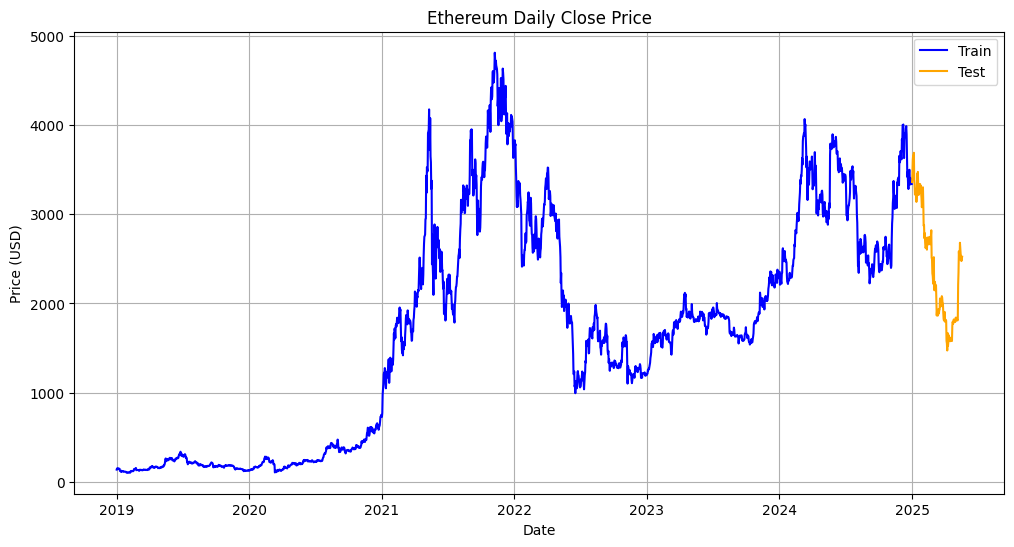

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train', color='blue')
plt.plot(test.index, test.values, label='Test', color='orange')
plt.title("Ethereum Daily Close Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Check stationarity

In [48]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.8324341245769769
p-value: 0.36448204756244484


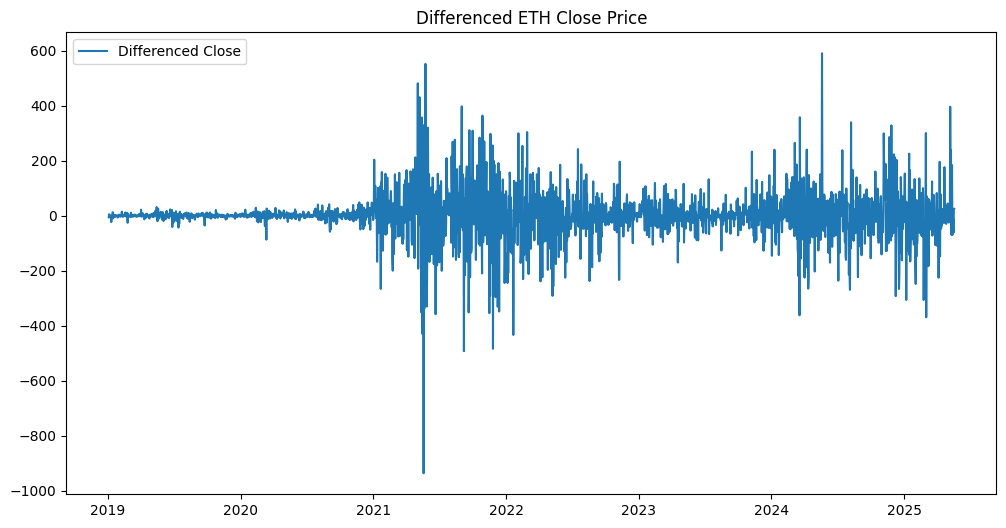

In [56]:
df['close_diff'] = df['close'].diff()
df.dropna(inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df['close_diff'], label='Differenced Close')
plt.title("Differenced ETH Close Price")
plt.legend()
plt.show()

In [64]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

train_scaled = pd.Series(train_scaled.flatten(), index=train.index)
test_scaled = pd.Series(test_scaled.flatten(), index=test.index)

In [65]:
model = SARIMAX(train_scaled, order=(1, 1, 1))
model_fit = model.fit(disp=False)

In [72]:
train_predictions = model_fit.predict(start=train_scaled.index[0], end=train_scaled.index[-1])
forecast_steps = len(test_scaled)
test_predictions = model_fit.forecast(steps=forecast_steps)
test_predictions = pd.Series(test_predictions, index=test_scaled.index)


In [75]:
# Remove any non-numeric or extra rows (like 'predictions') from both Series
test_scaled_clean = test_scaled[test_scaled.index != 'predictions'].astype(float)
test_predictions_clean = test_predictions[test_predictions.index != 'predictions'].astype(float)

mae = mean_absolute_error(test_scaled_clean, test_predictions_clean)
mse = mean_squared_error(test_scaled_clean, test_predictions_clean)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


Mean Absolute Error: 0.2043
Mean Squared Error: 0.0573
Root Mean Squared Error: 0.2393


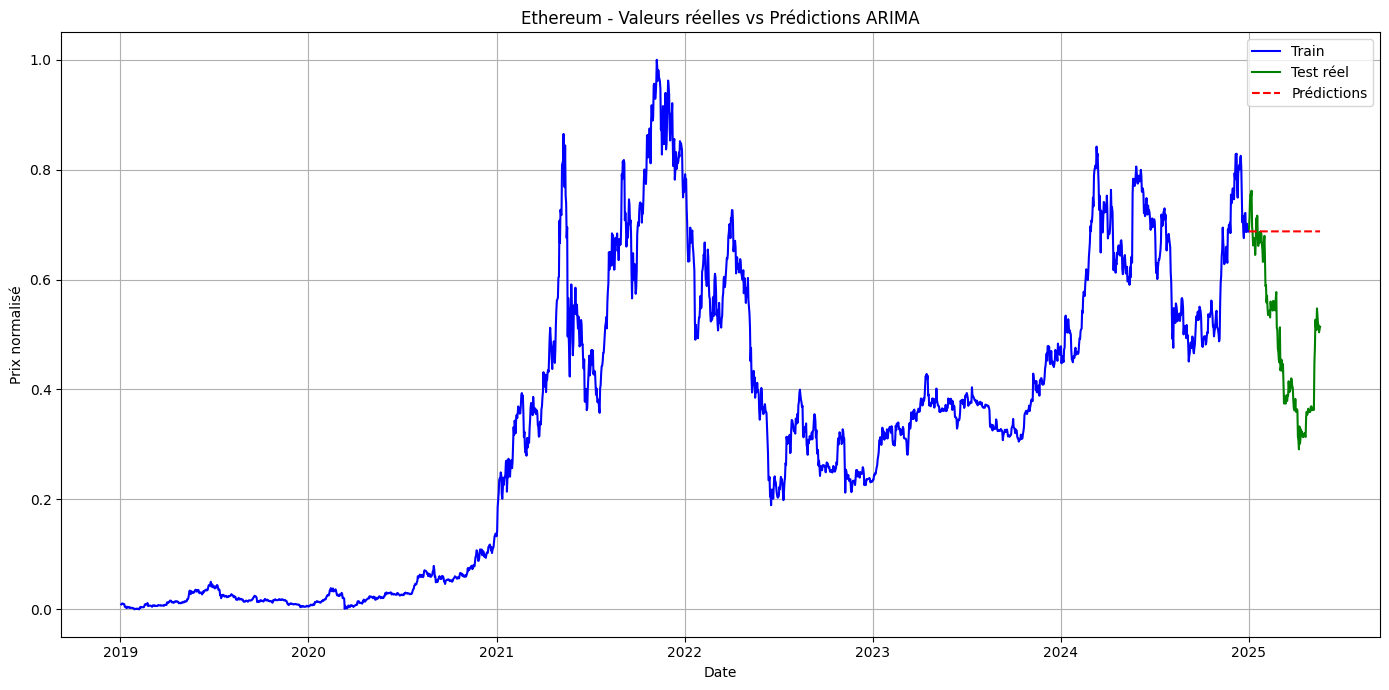

ValueError: x and y must have same first dimension, but have shapes (2191,) and (2190, 1)

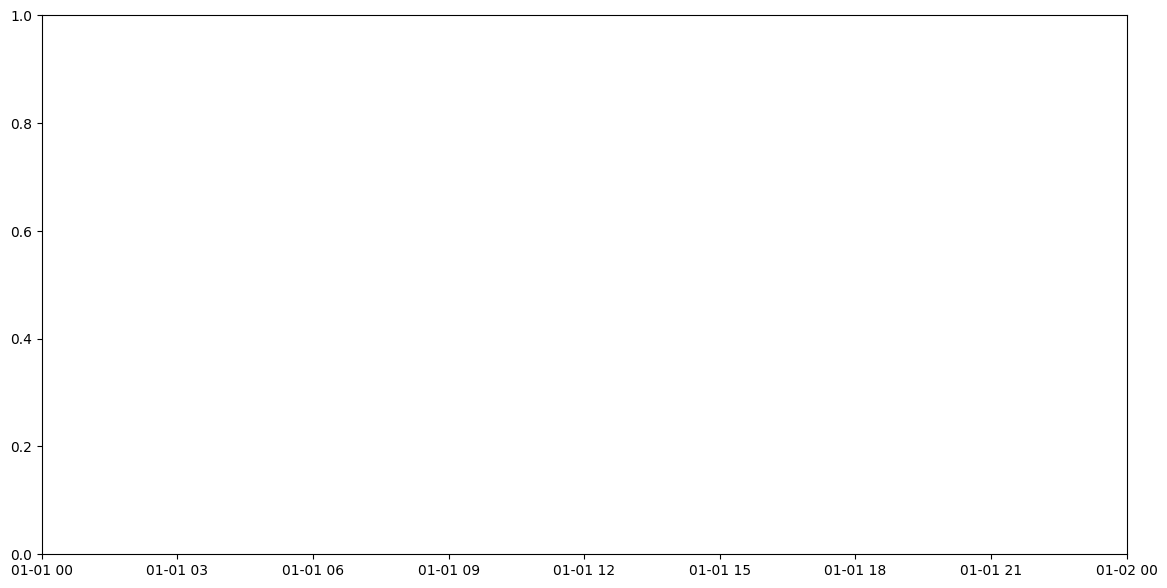

In [91]:
plt.figure(figsize=(14, 7))
plt.plot(train_scaled.index, train_scaled.values, label='Train', color='blue')
plt.plot(test_scaled_clean.index, test_scaled_clean.values, label='Test réel', color='green')
plt.plot(test_predictions_clean.index, test_predictions_clean.values, label='Prédictions', color='red', linestyle='--')
plt.title("Ethereum - Valeurs réelles vs Prédictions ARIMA")
plt.xlabel("Date")
plt.ylabel("Prix normalisé")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Reconversion des données à l'échelle originale
train_predictions_original = scaler.inverse_transform(train_predictions.values.reshape(-1, 1))
test_predictions_original = scaler.inverse_transform(test_predictions.values.reshape(-1, 1))
train_original = scaler.inverse_transform(train_scaled.values.reshape(-1, 1))
test_original = scaler.inverse_transform(test_scaled_clean.values.reshape(-1, 1))

# Visualisation à l'échelle originale
plt.figure(figsize=(14, 7))
plt.plot(train.index, train_original, label='Train', color='blue')
plt.plot(test.index, test_original, label='Test réel', color='green')
plt.plot(test.index, test_predictions_original, label='Prédictions', color='red', linestyle='--')
plt.title("Ethereum - Prix réels vs Prédictions ARIMA")
plt.xlabel("Date")
plt.ylabel("Prix (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcul des métriques sur les données à l'échelle originale
test_original_series = pd.Series(test_original.flatten(), index=test.index)
test_pred_original_series = pd.Series(test_predictions_original.flatten(), index=test.index)

mae_original = mean_absolute_error(test_original_series, test_pred_original_series)
mse_original = mean_squared_error(test_original_series, test_pred_original_series)
rmse_original = np.sqrt(mse_original)
mape = np.mean(np.abs((test_original_series - test_pred_original_series) / test_original_series)) * 100

print("\nMétriques d'évaluation (échelle originale):")
print(f"Mean Absolute Error: {mae_original:.2f} USD")
print(f"Mean Squared Error: {mse_original:.2f}")
print(f"Root Mean Squared Error: {rmse_original:.2f} USD")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")